In [2]:
import os
from monai.transforms import (
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    ToTensord,
    Resized,
    AsChannelLastd,
    AsChannelFirstd,
    AsDiscrete,
    CropForeground,
    SpatialCropd,
    AsDiscreted,
)
from monai.transforms.transform import MapTransform
from monai.transforms.inverse import InvertibleTransform
from monai.data import decollate_batch
import SimpleITK as sitk

from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from typing import Any, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union
import numpy as np

from monai.visualize import matshow3d, blend_images
import torch


In [2]:
class RemoveDicts(MapTransform, InvertibleTransform):
    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            self.push_transform(d, key)

        a = {}
        for key in self.key_iterator(d):
            a[key] = d[key]
            if key == "image":
                a["path"] = d["image_meta_dict"]["filename_or_obj"]
        if a.get("path", None) is None:
            a["path"] = d["label_meta_dict"]["filename_or_obj"]

        # a = {"image": d["image"], "label": d["label"], "label-gc":  d["label-gc"] , "path": d["image_meta_dict"]["filename_or_obj"]}

        # print(a["path"])
        d = a
        return d

    def inverse(self, data: Mapping[Hashable, Any]) -> Dict[Hashable, Any]:
        d = deepcopy(dict(data))
        for key in self.key_iterator(d):
            d[key] = d[key]
            # Remove the applied transform
            self.pop_transform(d, key)
        return d


In [3]:
from monai.transforms.intensity.array import ScaleIntensityRangePercentiles


class ScaleIntensityRangePercentilesd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.ScaleIntensityRangePercentiles`.

    Args:
        keys: keys of the corresponding items to be transformed.
            See also: monai.transforms.MapTransform
        lower: lower percentile.
        upper: upper percentile.
        b_min: intensity target range min.
        b_max: intensity target range max.
        clip: whether to perform clip after scaling.
        relative: whether to scale to the corresponding percentiles of [b_min, b_max]
        channel_wise: if True, compute intensity percentile and normalize every channel separately.
            default to False.
        dtype: output data type, if None, same as input image. defaults to float32.
        allow_missing_keys: don't raise exception if key is missing.
    """

    backend = ScaleIntensityRangePercentiles.backend

    def __init__(
        self,
        keys: KeysCollection,
        lower: float,
        upper: float,
        b_min: Optional[float],
        b_max: Optional[float],
        clip: bool = False,
        relative: bool = False,
        channel_wise: bool = False,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.scaler = ScaleIntensityRangePercentiles(
            lower, upper, b_min, b_max, clip, relative, channel_wise, dtype
        )

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.scaler(d[key])
        return d


In [50]:
class NNUnetScaleIntensity(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.ScaleIntensityRange`.

    Args:
        keys: keys of the corresponding items to be transformed.
            See also: monai.transforms.MapTransform
        a_min: intensity original range min.
        a_max: intensity original range max.
        b_min: intensity target range min.
        b_max: intensity target range max.
        clip: whether to perform clip after scaling.
        dtype: output data type, if None, same as input image. defaults to float32.
        allow_missing_keys: don't raise exception if key is missing.
    """

    def _compute_stats(self, volume, mask):
        volume = np.ma.masked_equal(volume.copy().astype(np.int16) * np.greater(mask, 0), 0).compressed()
        median = np.median(volume)
        mean = np.mean(volume)
        std = np.std(volume)
        mn = np.min(volume)
        mx = np.max(volume)
        percentile_99_5 = np.percentile(volume, 99.5)
        percentile_00_5 = np.percentile(volume, 00.5)
        print(median, mean, std, mn, mx, percentile_99_5, percentile_00_5)
        return median, mean, std, mn, mx, percentile_99_5, percentile_00_5

    def __init__(
        self,
        keys: KeysCollection,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            stats = self._compute_stats(d[key], d["label"])
            d[key] = np.clip(d[key], stats[6], stats[5])
            d[key] = (d[key] - stats[1]) / stats[2]
        return d


In [5]:
class WriteToMHA(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        output_dir: str,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.output_dir = output_dir

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            if isinstance(d[key], torch.Tensor):
                d[key] = d[key].detach().cpu().numpy().astype(np.int8)
            original = sitk.ReadImage(d["path"])
            filename = os.path.basename(d["path"]).split(".")[0] + ".mha"
            save_dir = os.path.join(self.output_dir, filename)
            if not os.path.exists(os.path.dirname(save_dir)):
                print(f"Creating directory: {os.path.dirname(save_dir)}")
                os.makedirs(os.path.dirname(save_dir))
            print(f"Saving to {save_dir}")
            img = sitk.GetImageFromArray(d[key])
            img.SetSpacing(original.GetSpacing())
            img.SetOrigin(original.GetOrigin())
            sitk.WriteImage(img, save_dir)

        return d


In [6]:
import cv2


class CreateSyntheticLabel(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        threshold: float = 0.5,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.threshold = threshold

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        print(d["label"].shape)
        old_mask = d["label"][3, :, :, :].unsqueeze(0).numpy().copy()
        new_mask = np.zeros_like(old_mask)
        new_img = d["image"][:, :, :, :].numpy().copy()
        idx_label = np.where(old_mask.flatten() == 1)[0]
        idx_img = np.where(new_img.flatten() > self.threshold)[0]
        idx_to_change = np.intersect1d(idx_img, idx_label)
        np.put(new_mask, idx_to_change, 1)
        old_mask -= new_mask

        kernel = np.ones((4, 4), np.uint8)
        closed_slices = list()
        for slice in range(new_mask.shape[-1]):
            result = cv2.morphologyEx(
                new_mask[0, :, :, slice], cv2.MORPH_CLOSE, kernel, iterations=2
            )
            result = cv2.medianBlur(result, 3)
            closed_slices.append(result)

        new_mask = np.stack(closed_slices)

        d["label"][1, :, :, :] = torch.Tensor(new_mask).permute(1, 2, 0)
        d["label"][3, :, :, :] = torch.Tensor(old_mask)

        return d


In [7]:
class AddGCLabel(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        threshold: float = 0.5,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)
        self.threshold = threshold

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:

        d = dict(data)
        print(d["label"].shape, d["label-gc"].shape)
        spleen_channel = np.where((d["label-gc"] != 1), 0, d["label-gc"])
        spleen_channel = np.where((spleen_channel == 1), 1, spleen_channel)
        print(d["label"].shape, d["label-gc"].shape)
        d["label"][1, :, :, :] = (
            torch.Tensor(spleen_channel).unsqueeze(0) - d["label"][3, :, :, :]
        )

        return d


In [8]:
class AsDiscrete1sd(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:

        d = data
        d["label"] = d["label"].astype(np.int8)
        back = np.expand_dims(np.zeros(d["label"][0, :, :, :].shape, dtype=np.int8), 0)
        d["label"] = torch.Tensor(np.append(back, d["label"], axis=0))
        print(d["label"].shape)
        return d


In [9]:
class RemoveBackgroundd(MapTransform):
    def __init__(
        self,
        keys: KeysCollection,
        allow_missing_keys: bool = False,
    ) -> None:
        super().__init__(keys, allow_missing_keys)

    def __call__(
        self, data: Mapping[Hashable, NdarrayOrTensor]
    ) -> Dict[Hashable, NdarrayOrTensor]:

        d = data
        print("before: ", d["label"].shape)
        d["label"] = d["label"][1:, :, :, :]
        return d


In [143]:
import matplotlib.pyplot as plt
from ipywidgets.widgets import *
import ipywidgets as widgets
import matplotlib.pyplot as plt
import glob

injure_liver = os.path.join(
    "/mnt/chansey/",
    "lauraalvarez",
    "nnunet",
    "nnUNet_raw_data_base",
    "nnUNet_raw_data",
    "Task504_LiverTrauma",
    "imagesTr",
    "TRMLIV_000_0000.nii.gz",
)
injure_liver_label = os.path.join(
    "/mnt/chansey/",
    "lauraalvarez",
    "nnunet",
    "nnUNet_raw_data_base",
    "nnUNet_raw_data",
    "Task504_LiverTrauma",
    "labelsTr",
    "TRMLIV_000.nii.gz",
)

spleen_error_img = os.path.join(
    "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task504_LiverTrauma", "imagesTs", "TRMLIV_000_0000.nii.gz"
)
spleen_error_msk = os.path.join(  "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task504_LiverTrauma", "out", "TRMLIV_000.nii.gz")
spleen_error_true = os.path.join(
    "U:\\", "lauraalvarez", "nnunet", "nnUNet_raw_data", "Task504_LiverTrauma", "labelsTs", "TRMLIV_000.nii.gz"
)

# spleen_error_img = os.path.join(
#     "/mnt/chansey/", "lauraalvarez", "data", "liver", "train", "data", "L110086.mha"
# )
# spleen_error_msk = os.path.join(  "/mnt/chansey/", "lauraalvarez", "data", "liver", "train", "mask", "L110086.mha")
# spleen_error_msk = os.path.join(
#     "/mnt/chansey/",
#     "lauraalvarez",
#     "data",
#     "_overlays_from_alessa",
#     "overlays",
#     "overlay_B2",
#     "L110027.mha",
# )
# gc_msk = os.path.join("/mnt/chansey/", "lauraalvarez", "data", "liver")

selected_img = spleen_error_img
selected_msk = spleen_error_msk
selected_true = spleen_error_true


In [157]:
paths = {"label": selected_msk, "image": selected_img, "tLabel": selected_true}
normal_plot = Compose(
    [
        LoadImaged(keys=["image","label","tLabel"]),
        AsChannelFirstd(keys=["image","label","tLabel"]),
        AddChanneld(keys=["label","image", "tLabel"]),
        Orientationd(keys=["image", "label", ], axcodes="RAS"),
        NNUnetScaleIntensity(keys=["image"]),
        # Resized(keys=["image","label"], spatial_size=(160,160,160)),
    ]
)
# val_transforms_overlays_float_class = Compose(
#     [
#         LoadImaged(keys=["label"]),
#         RemoveDicts(keys=["label"]),
#         AsChannelFirstd(keys=["label"]),
#         AsDiscrete1sd(keys=["label"]),
#         AsDiscreted(keys=["label"], argmax=True, to_onehot=7),
#         RemoveBackgroundd(keys=["label"]),
#         WriteToMHA(
#             keys=["label"],
#             output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays",
#         ),
#     ]
# )

# val_transforms_insert_gc_overlay = Compose( #igual no es asi
#     [
#         LoadImaged(keys=["image", "label", "label-gc"]),
#         RemoveDicts(keys=["image", "label", "label-gc"]),
#         adaptOverlay(keys=["label-gc"]),
#         AsChannelFirstd(keys=["label", "label-gc"]),
#         AddGCLabel(keys=["label"]),
#         WriteToMHA(keys=["label"], output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays"),
#     ]
# )

# val_transforms_synthetic_spleen = Compose(
#     [
#         LoadImaged(keys=["image", "label"]),
#         RemoveDicts(keys=["image", "label"]),
#         AddChanneld(keys=["image"]),
#         AsChannelFirstd(keys=["label"]),
#         NNUnetScaleIntensity(keys=["image"]),
#         ToTensord(keys=["image", "label"]),
#         CreateSyntheticLabel(keys=["label"], threshold=0.5),
#         # Resized(keys=["image", "label"], spatial_size=(259, 259, 259))
#         WriteToMHA(
#             keys=["label"],
#             output_dir="/mnt/chansey/lauraalvarez/data/spleen/synthetic_overlays",
#         ),
#     ]
# )
injures = normal_plot(paths)

print(injures["label"].shape)
print(injures["image"].shape)
# print(np.unique(injures["label"]))


126.0 125.40829693965654 32.8002518141156 -82 444 218.0 33.0
(1, 1265, 512, 512)
(1, 1265, 512, 512)


In [164]:
inj =  dict(injures)
inj =Resized(keys=["image", "label", "tLabel"], spatial_size=(160, 160, 160))(inj)
# injures["label"] = np.expand_dims(injures["label"],0)
# injures["image"] = np.expand_dims(injures["image"],0)
print(inj["label"].shape)
print(inj["image"].shape)

(1, 160, 160, 160)
(1, 160, 160, 160)


In [165]:
post_pred_blending = Compose([AsDiscrete(argmax=True)])
injures_one_channel = post_pred_blending(injures["label"])
blended_label_in = blend_images(
    inj["image"], inj["label"], 0.5
)
blended_final = torch.from_numpy(blended_label_in).permute(1, 2, 0, 3)

blended_true_label = blend_images(inj["image"], inj["tLabel"], 0.5)
blended_true_label = torch.from_numpy(blended_true_label).permute(1, 2, 0, 3)


In [174]:
print(torch.from_numpy(inj["image"]).permute(1,2,0,3).repeat(1,1,3,1).shape)
print(blended_final.shape)

torch.Size([160, 160, 3, 160])
torch.Size([160, 160, 3, 160])


In [175]:
volume = torch.hstack((torch.from_numpy(inj["image"]).permute(1,2,0,3).repeat(1,1,3,1), blended_final, blended_true_label))
print(volume.shape)
volume = volume.permute(0,1,3,2)
print(volume.shape)

torch.Size([160, 480, 3, 160])
torch.Size([160, 480, 160, 3])


In [168]:
import imageio
def _save_gif(volume, filename):
    volume = volume.astype(np.float64) / np.max(volume) # normalize the data to 0 - 1
    volume = volume *255 # Now scale by 255
    volume = volume.astype(np.uint8)
    path_to_gif = os.path.join("gifs", f'{filename}.gif')
    if not os.path.exists("gifs"):
        print("Creating gifs directory")
        os.mkdir("gifs")
    imageio.mimsave(path_to_gif, volume)
    return path_to_gif

In [171]:
blended_final.shape

torch.Size([160, 160, 3, 160])

In [176]:
volume_path = _save_gif(blended_final.numpy().transpose(0,1,3,2), f"blended-test-11")

In [150]:
def dicom_animation(slice):
    f, axarr = plt.subplots(1, 3, figsize=(20, 20))
    plt.title(f"liver no injured ")
    axarr[0].imshow(blended_final[:, :, :, slice])
    axarr[1].imshow(blended_true_label[:, :, :, slice])
    axarr[2].imshow(inj["image"][0, :, :, slice], cmap="bone")
    # axarr[2].imshow(new_mask[0, :, :, slice])
    # axarr[1].imshow(injures["label"][1, :, :, slice], cmap="bone")


interact(dicom_animation, slice=(0, inj["label"].shape[-1] - 1))


interactive(children=(IntSlider(value=79, description='slice', max=159), Output()), _dom_classes=('widget-inte…

<function __main__.dicom_animation(slice)>

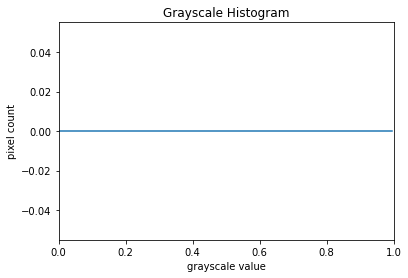

In [22]:
# select pixels of injury mask
injury_mask = injures["label"][3, :, :, :]
values = injures["image"][0, :, :, :][injury_mask == 1]
histogram, bin_edges = np.histogram(values, bins=256, range=(0, 1))

# configure and draw the histogram figure
plt.figure()
plt.title("Grayscale Histogram")
plt.xlabel("grayscale value")
plt.ylabel("pixel count")
plt.xlim([0.0, 1.0])  # <- named arguments do not work here

plt.plot(bin_edges[0:-1], histogram)  # <- or here
plt.show()


In [55]:
values


tensor([-3.6025, -1.5511, -1.3500,  ..., -0.4651, -0.6260, -0.7467])